# Data Cleaning and Feature Engineering -ET_project




In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score

In [2]:
df= pd.read_csv('/Users/miguelaraujo/code/MrAraujo99/ET_Predictor/raw_data/UFO sightings/scrubbed.csv')

/var/folders/0m/p33mzd1n3nq5v3977g7mxf1r0000gn/T/ipykernel_10524/3933699196.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('/Users/miguelaraujo/code/MrAraujo99/ET_Predictor/raw_data/UFO sightings/scrubbed.csv')


In [3]:
# Filter the dataset for US and Canada
df = df[df['country'].isin(['us', 'ca'])]

### Convert 'datetime' to datetime object and Extract day, hour, and week and season

In [4]:
df.columns = df.columns.str.strip()# Convert 'latitude' and 'longitude' to numeric types, coerce errors
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
# Convert 'datetime' to datetime object, coerce errors
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Extract day, hour, and week from the datetime column
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['week'] = df['datetime'].dt.isocalendar().week

In [5]:
# Function to determine season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

df['month'] = df['datetime'].dt.month
df['season'] = df['month'].apply(get_season)

#### Defining X and y

In [6]:
# Drop rows where datetime could not be converted
df.dropna(subset=['datetime'], inplace=True)

# Define features and target variable
X = df.drop(columns=['latitude', 'longitude'])
y = df[['latitude', 'longitude']]


In [7]:
# Remove rows where the target variable has NaN values
mask = ~y.isna().any(axis=1)
X = X[mask]
y = y[mask]


### Train_test_split

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:

# Define preprocessing for numerical and categorical features
numeric_features = ['day', 'hour', 'week', 'month']
numeric_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

categorical_features = ['season']
categorical_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), OneHotEncoder(handle_unknown='ignore'))

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


### applying preprocessing

In [10]:
# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

#### play with the n_clusters to check if its always 1 and grid search with n_neighbours


In [11]:
# Clustering using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_train = kmeans.fit_predict(X_train_preprocessed)
clusters_test = kmeans.predict(X_test_preprocessed)

In [12]:
# Add cluster labels to the training data
X_train_clustered = np.hstack((X_train_preprocessed, clusters_train.reshape(-1, 1)))
X_test_clustered = np.hstack((X_test_preprocessed, clusters_test.reshape(-1, 1)))

In [13]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)

### Fitting , evaluating and predicting

In [14]:
# Fit the KNN model on the clustered training data
knn.fit(X_train_clustered, clusters_train)

# Predict on the test data
y_pred = knn.predict(X_test_clustered)

# Evaluate the model
accuracy = accuracy_score(clusters_test, y_pred)
silhouette = silhouette_score(X_test_clustered, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Silhouette Score: {silhouette}')

Accuracy: 1.0
Silhouette Score: 0.4723043160296571


#### Cross validation

In [15]:

# Perform cross-validation manually for silhouette score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
silhouette_scores = []

for train_index, val_index in cv.split(X_train_clustered, clusters_train):
    X_cv_train, X_cv_val = X_train_clustered[train_index], X_train_clustered[val_index]
    y_cv_train, y_cv_val = clusters_train[train_index], clusters_train[val_index]
    
    knn.fit(X_cv_train, y_cv_train)
    y_cv_pred = knn.predict(X_cv_val)
    
    accuracy_scores.append(accuracy_score(y_cv_val, y_cv_pred))
    silhouette_scores.append(silhouette_score(X_cv_val, y_cv_pred))

print(f'Cross-Validation Accuracy: {np.mean(accuracy_scores)}')
print(f'Cross-Validation Silhouette Score: {np.mean(silhouette_scores)}')

Cross-Validation Accuracy: 1.0
Cross-Validation Silhouette Score: 0.4711238444638527


#### Visualizing the clusters

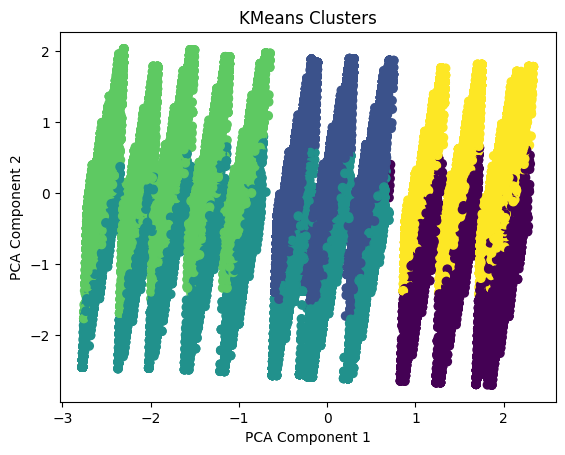

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_preprocessed)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_train, cmap='viridis')
plt.title('KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Key Points:

    Distinct Clusters: If the colors are well-separated, it indicates distinct clusters.
    Overlap: If the colors overlap significantly, it indicates that the clusters are not well-separated.

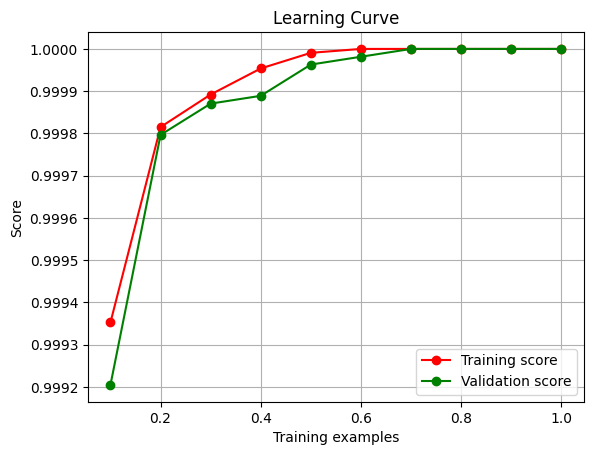

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def plot_learning_curve(estimator, X, y, cv, scoring='accuracy'):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores = []
    val_scores = []

    for train_size in train_sizes:
        train_scores_fold = []
        val_scores_fold = []

        for train_index, val_index in cv.split(X, y):
            X_cv_train, X_cv_val = X[train_index], X[val_index]
            y_cv_train, y_cv_val = y[train_index], y[val_index]

            # Sample a subset of the training data
            subset_size = int(train_size * len(X_cv_train))
            X_train_subset = X_cv_train[:subset_size]
            y_train_subset = y_cv_train[:subset_size]

            # Train the estimator
            estimator.fit(X_train_subset, y_train_subset)

            # Calculate training and validation scores
            y_train_pred = estimator.predict(X_train_subset)
            y_val_pred = estimator.predict(X_cv_val)

            train_scores_fold.append(accuracy_score(y_train_subset, y_train_pred))
            val_scores_fold.append(accuracy_score(y_cv_val, y_val_pred))

        train_scores.append(np.mean(train_scores_fold))
        val_scores.append(np.mean(val_scores_fold))

    plt.figure()
    plt.plot(train_sizes, train_scores, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_scores, 'o-', color='g', label='Validation score')
    plt.title('Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Perform cross-validation manually for KNN classifier
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Combine training data with cluster labels
X_combined = np.hstack((X_train_preprocessed, clusters_train.reshape(-1, 1)))

# Plot learning curve for KNN classifier
plot_learning_curve(knn, X_combined, clusters_train, cv)
